# West Nile Virus Mosquito Analysis

https://www.kaggle.com/c/predict-west-nile-virus


<img align="right" src='https://kaggle2.blob.core.windows.net/competitions/kaggle/4366/media/moggie2.png' width=8%>

By: 顾 瞻 GU Zhan (Sam)

June 2017

# Table of Content

[1] Prior arts
    
    
[2] Data pre-porcessing
    
    
[3] Modeling
    
    
[4] Evaluation
    
    
[5] What more can be done?

# [1] Prior arts

https://www.kaggle.com/c/predict-west-nile-virus/leaderboard

<img align="left" src='./ref/LB.png' width=100%>


### 1st prize winner: Chaim Linhart (Cardal)

https://github.com/Cardal/Kaggle_WestNileVirus

**Method:**

Heavy probability and curve-fitting techniques were used: using training data to calculated probability/bias based on many data features to infer the impact/coefficient onto wnv probability, i.e. Normal approximation of the distribution of WnvPresent along a year; Trap-bias (the fraction of rows (in that trap) that contain WnvPresent=1 divided by the global ratio of WnvPresent=1); Estimation for number of mosquitoes per row by looking at similar rows (using dist_days, dist_geospace, and species).
Some heuristics are used, i.e. outbreaks_daily_factors
Leaderboard feedback was used.

To calculate a test wnv probability: Adopt a normal distribution as baseline for prediction of all new test cases.
Then apply various above mentioned 'coefficients' to adjust the final results. Leaderboard feedback is incorporated as probability multiplier.

**Dataset used:** train.csv, leaderboard

### 2nd prize winner: Lucas Silva & Dmitry Efimov

https://github.com/diefimov/west_nile_virus_2015

**Method:**
Ensemble modelling using: Gradient Boosting Classifier & Regularized Greedy Forest, with two different structured input files.
Mosquitoes data and weather data are linked/combined based on 'date' feature, plus Structural features: i.e. TrapCount (number of mosquitos batches for fixed Trap, Date, Species), TrapCountPrevAge, TrapCountPrev.
Used Leaderboard feedback: Two types of multipliers have been applied. AUC scores for each year have been obtained from the leaderboard. Using these AUC scores we have constructed the linear regression model to predict relative average PAyear of WnvPresent for each year, the same way we have obtained the relative average PAmonth of WnvPresent by months 


**Dataset used:** train.csv, weather.csv, leaderboard

### <font color='blue'>[Sam] In this exercise, we are to use all three datasets: train, weather, and spray.</font> 

# [2] Data pre-porcessing
Explore and visualize data

In [1]:
# from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import operator
from scipy import interp
from itertools import cycle
from sklearn import svm
from sklearn.utils.validation import check_random_state
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from statsmodels.graphics.mosaicplot import mosaic
print(__doc__)

Automatically created module for IPython interactive environment


# Import raw data

### Input: train.csv

In [2]:
df_wnv_raw_train = pd.read_csv('train.csv', encoding='utf-8') 
df_wnv_raw_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [3]:
df_wnv_raw_train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [4]:
df_wnv_raw_train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


<img align="left" src='http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2015/07/Screen-Shot-2015-07-02-at-2.47.02-PM.png' width=100%>

*Above figure is obtained from internet.*

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


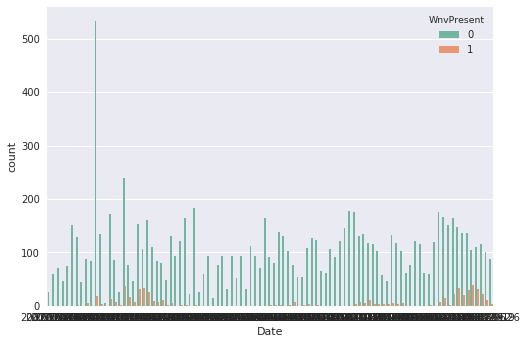

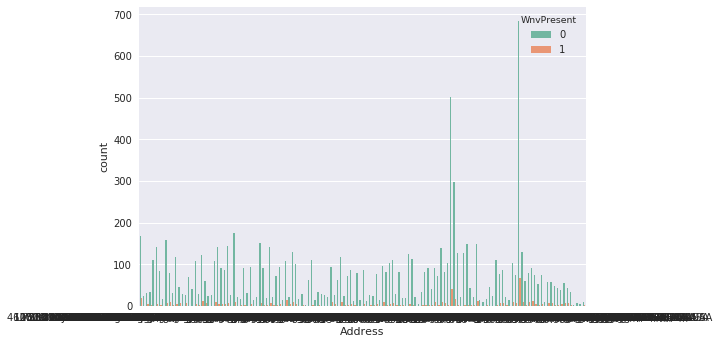

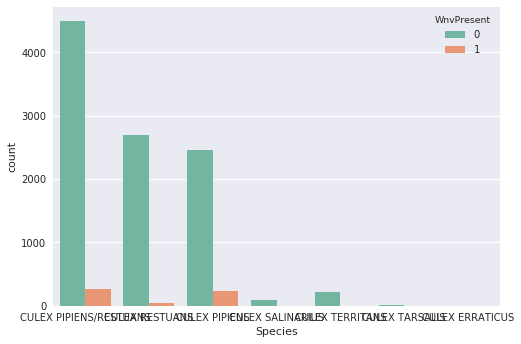

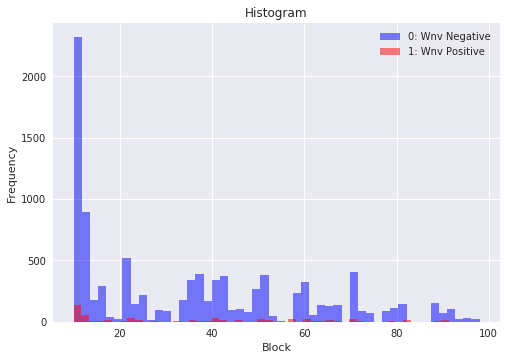

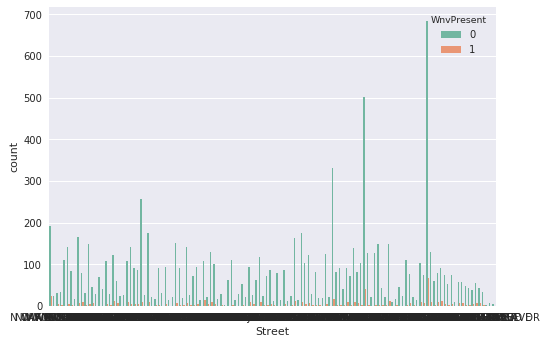

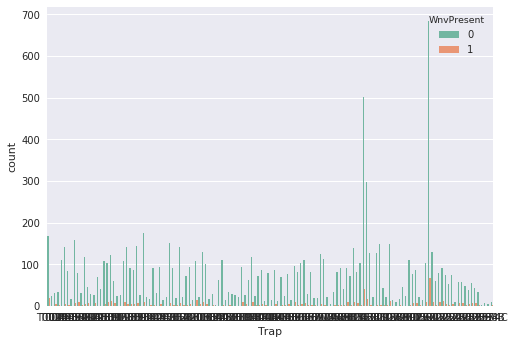

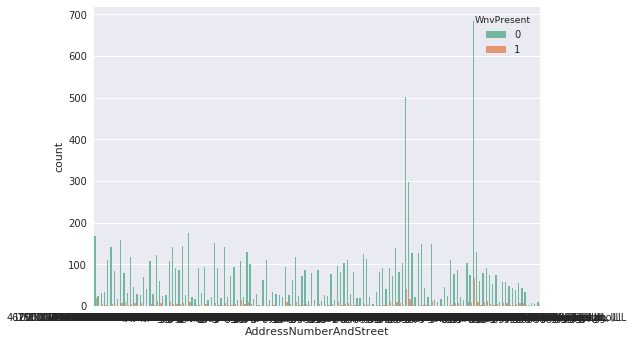

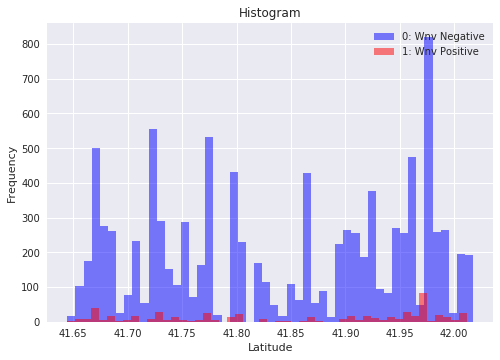

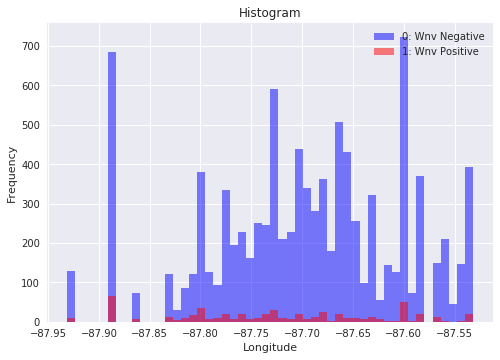

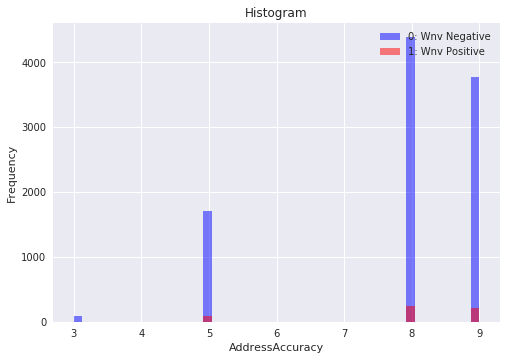

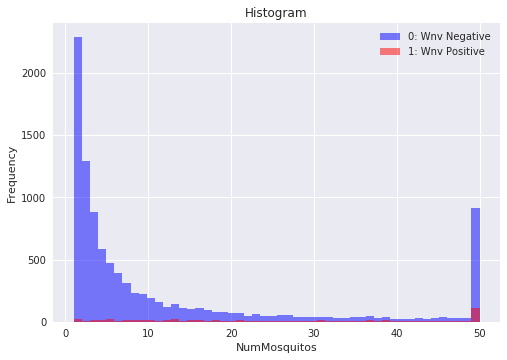

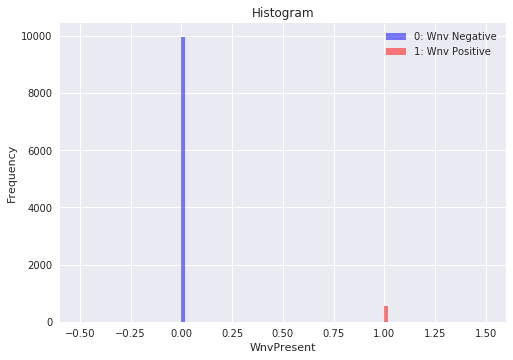

In [5]:
for i, col in enumerate(df_wnv_raw_train.columns):
    try:
        plt.figure(i)
        var1 = df_wnv_raw_train[df_wnv_raw_train['WnvPresent'] == 1][col]
        var2 = df_wnv_raw_train[df_wnv_raw_train['WnvPresent'] != 1][col]
        plt.hist(var2, histtype='stepfilled', bins=50, normed=False, color='blue', alpha=0.5, label='0: Wnv Negative')
        plt.hist(var1, histtype='stepfilled', bins=50, normed=False, color='red', alpha=0.5, label='1: Wnv Positive')
        plt.title("Histogram")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    #     plt.yscale('log')
        plt.legend()
        plt.show()
    except:
        plt.figure(i)
        sns.countplot(x=col, hue="WnvPresent", data=df_wnv_raw_train, palette="Set2")

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


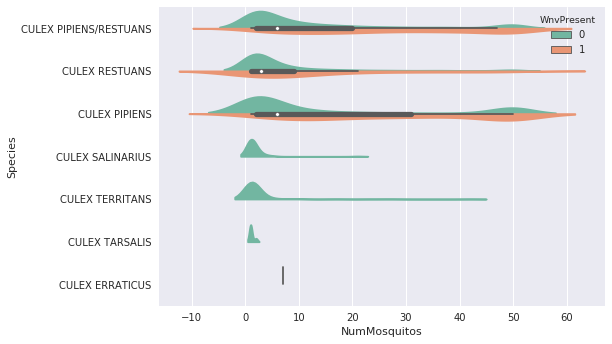

In [6]:
sns.violinplot(y="Species", x="NumMosquitos", hue="WnvPresent", data=df_wnv_raw_train, split=True, palette="Set2")

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


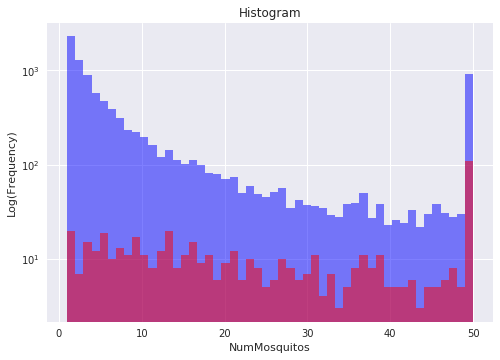

In [7]:
        col = 'NumMosquitos'
        var1 = df_wnv_raw_train[df_wnv_raw_train['WnvPresent'] == 1][col]
        var2 = df_wnv_raw_train[df_wnv_raw_train['WnvPresent'] != 1][col]
        plt.hist(var2, histtype='stepfilled', bins=50, normed=False, color='blue', alpha=0.5, label='0: Wnv Negative')
        plt.hist(var1, histtype='stepfilled', bins=50, normed=False, color='red', alpha=0.5, label='1: Wnv Positive')
        plt.title("Histogram")
        plt.xlabel(col)
        plt.yscale('log')
        plt.ylabel("Log(Frequency)")

### <font color='blue'>[Sam] Insights:</font> 
* monthly seasonality
* Three mosquito species have WNV
* 'Latitude' suggests northern and southern areas with more WNV
* WNV is more likey to be found in larger batch of trapped mosquito

### Strategy of Mosquito data pre-processing:

* Due to 50 mosquitoes cap per batch in data system, group batches on same date, trap, species.
* Construct more structural features, to incorporate previous & related rows' info into current row.


### Input: weather.csv

In [8]:
df_wnv_raw_weather = pd.read_csv('weather.csv', encoding='utf-8') 
df_wnv_raw_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [9]:
df_wnv_raw_weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [10]:
df_wnv_raw_weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


<img align="left" src='https://kaggle2.blob.core.windows.net/forum-message-attachments/76765/2432/closeststation.png' width=100%>

*Above figure is obtained from internet.*

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


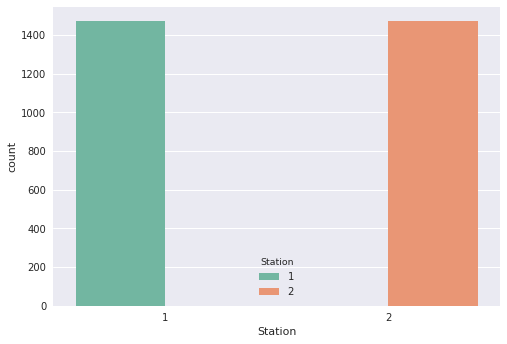

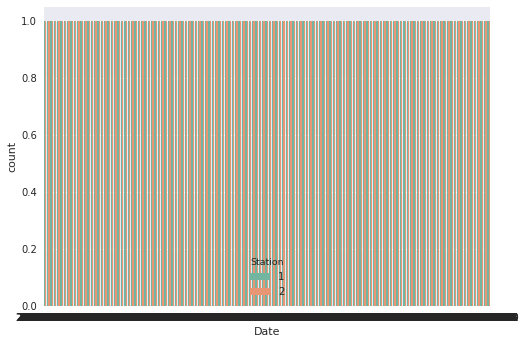

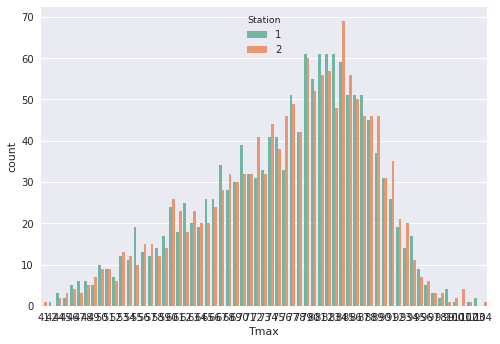

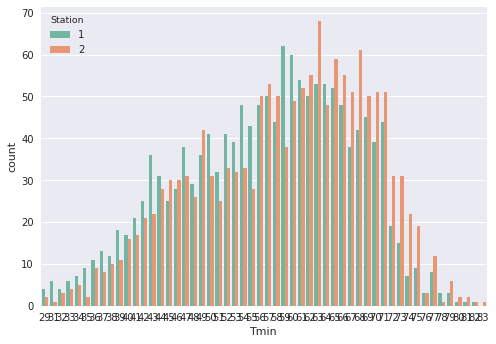

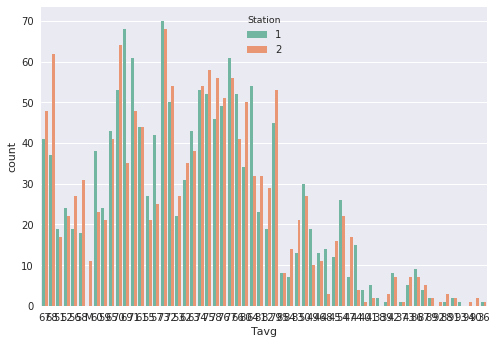

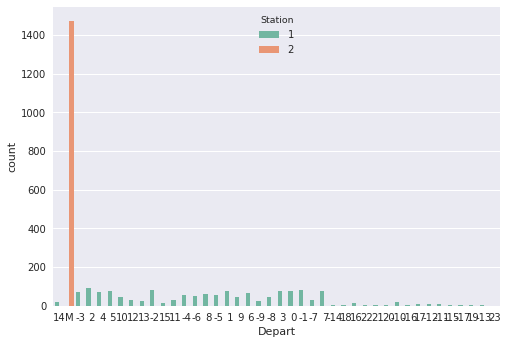

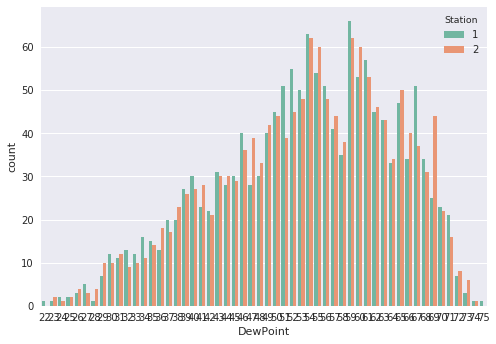

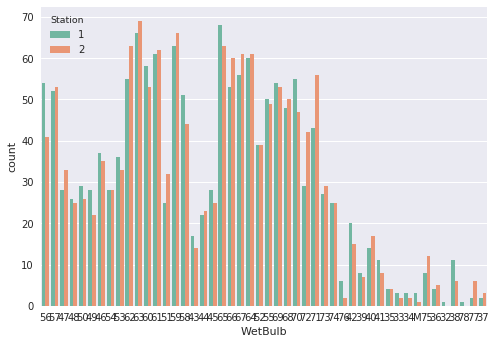

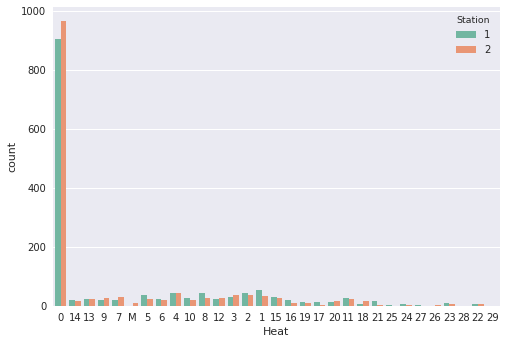

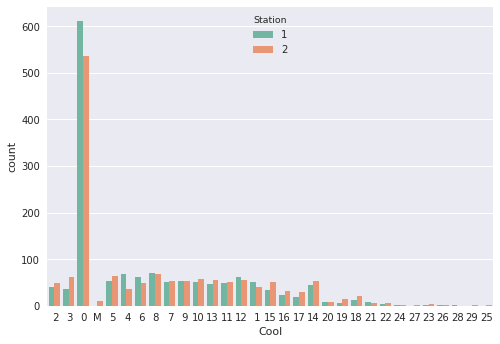

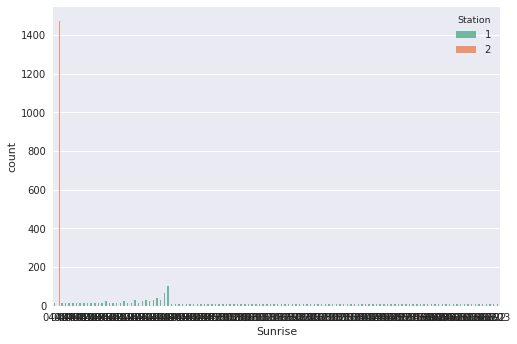

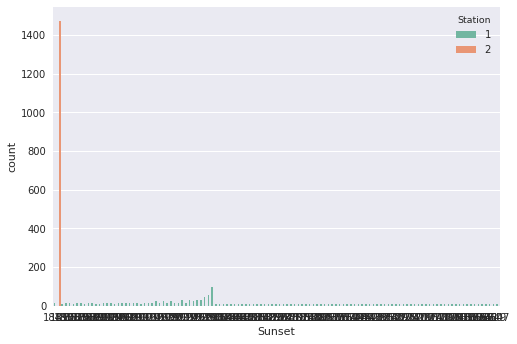

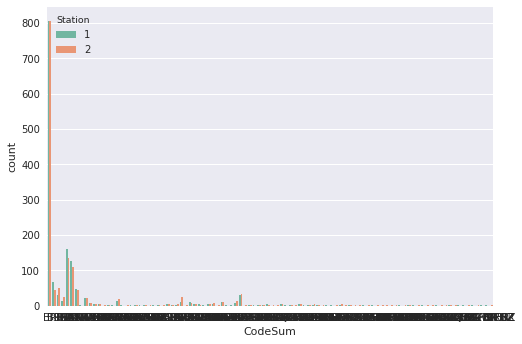

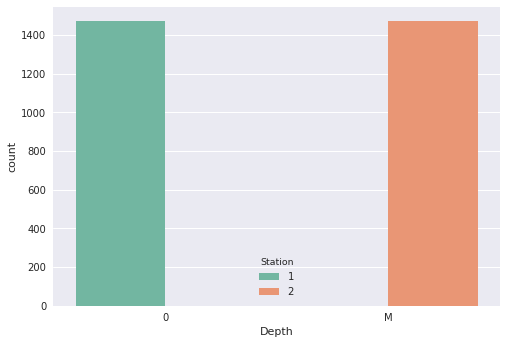

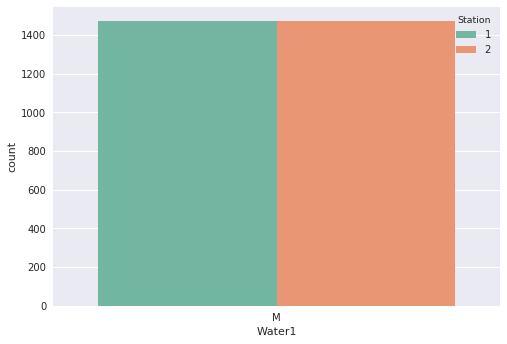

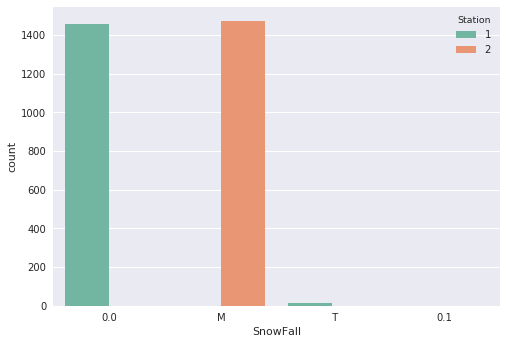

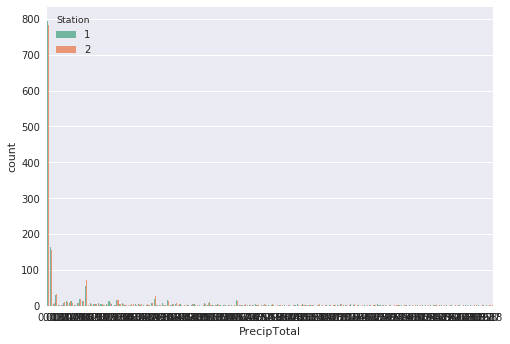

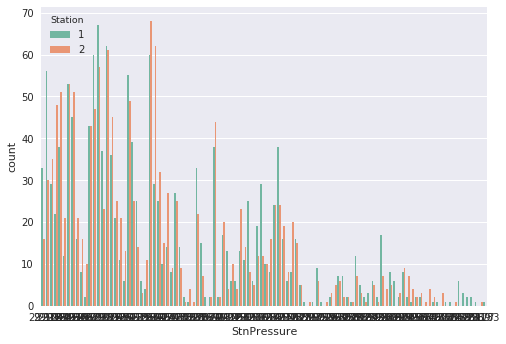

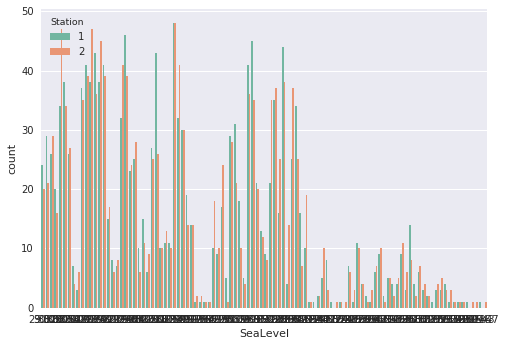

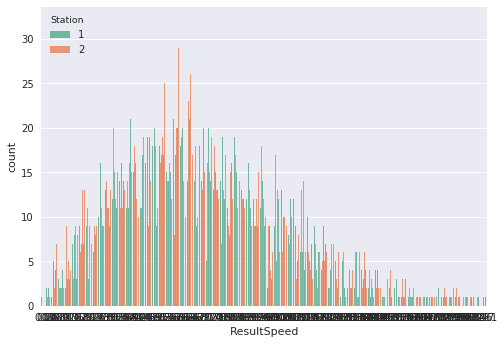

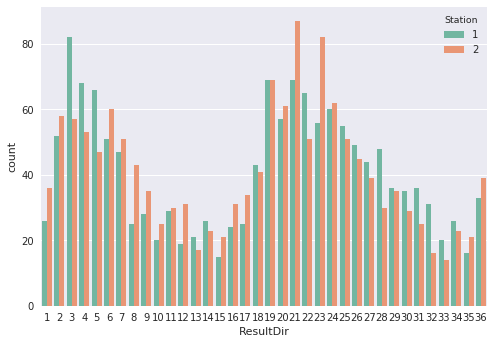

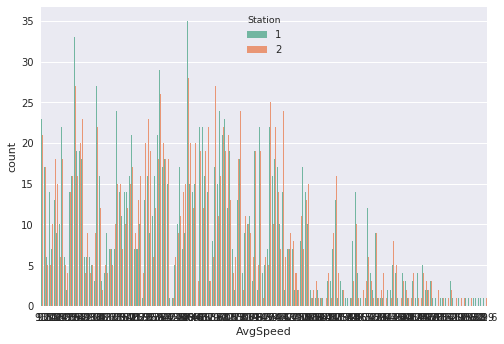

In [11]:
for i, col in enumerate(df_wnv_raw_weather.columns):
        plt.figure(i)
        sns.countplot(x=col, hue="Station", data=df_wnv_raw_weather, palette="Set2")

### <font color='blue'>[Sam] Insights:</font> 
* Similar data in Station 1 & 2
* Many missing values of Sataion 2
* Some features have very few different values.

### Strategy of Weather data pre-rpocessing:

Use station 1 data (more complete) as station 1 and 2 are correlated.


Impute missing values inbetween station 1 and 2.

Features not to use:
* CodeSum 
* Depth	
* Water1	
* SnowFall	
* PrecipTotal

### Input: spray.csv

In [12]:
df_wnv_raw_spray = pd.read_csv('spray.csv', encoding='utf-8') 
df_wnv_raw_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [13]:
df_wnv_raw_spray.columns

Index(['Date', 'Time', 'Latitude', 'Longitude'], dtype='object')

In [14]:
df_wnv_raw_spray.describe()

,Latitude,Longitude
count,14835.000000,14835.000000
mean,41.904828,-87.736690
std,0.104381,0.067292
min,41.713925,-88.096468
25%,41.785001,-87.794225
50%,41.940075,-87.727853
75%,41.980978,-87.694108
max,42.395983,-87.586727


<img align="left" src='https://kaggle2.blob.core.windows.net/competitions/kaggle/4366/media/all_loc_trap.png' width=100%>

*Above figure is obtained from internet.*

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


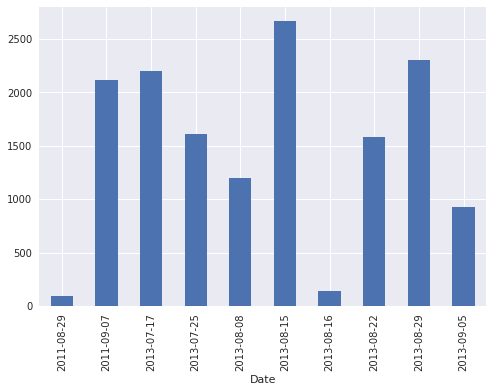

In [15]:
df_wnv_raw_spray.groupby(['Date']).size().plot(kind='bar')
# sns.countplot(y='Date', data=df_wnv_raw_spray, palette="Set2")

### Compare above few Spray events & WNV mosquito numbers:

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


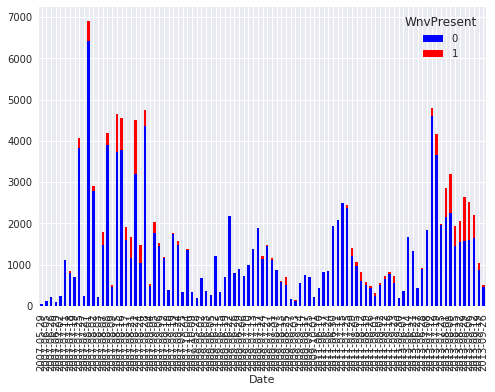

In [16]:
df_wnv_raw_train.groupby(['Date', 'WnvPresent'])['NumMosquitos'].sum().unstack().plot(kind='bar', stacked=True, color=['b', 'r'])

<img align="left" src='./ref/p1.png' width=100%>

### <font color='blue'>[Sam] Insights:</font> 
* Spray happened in year 2011 and 2013 only.
* Decrease of mosquito numbers were seen in Auguest 2011, 2013, suggesting effective spraying.
* Spray killed more non-wnv mosquitos then wnv ones.
* My internet research: Spray is effective for max 4 months, or undergoing 3 rains.

### Strategy of Spray data pre-processing:

Later analysis suggests trapped mosquito number is linked to wnv, thus in order to reflect spray effects in few years in training data, a multiplier is designed to artificially boost number of trapped mosquitoes, which would not have been killed if no spay applied, in year 2011 & 2013 only.)

# [3] Modeling Part 1: Pre-modeling in R

To quickly explore data interactively and get feelings of different models' potential.

### <font color='blue'>Pre-process data in R and Excel (outside of this notebook)</font>

* Use **train.csv** as base: Re-Code Block, Trap, and Species by desc sorting the occurrence of wnv: (number of positive wnv / total number of the feature, aggregated in train.csv).
* Aggregate rows based on Date, Trap, Species, to generate new NumMosquitosCombined. This is to handle 50 mosquito cap limit.
* De-Duplicate rows based on Date, Trap, and Species
* Add new feature NumMosPreTrapSpecies: current row's most recent previous NumMosquitosCombined, which has same Trap, Species as current row.
* Add new feature WnvPresentPreTrapSpecies: current row's most recent previous WnvPresent, which has same Trap, Species as current row.
* Add new feature NumMosPreBlockSpecies: current row's most recent previous NumMosquitosCombined, which has same Block, Species as current row.
* Add new feature WnvPresentPreBlockSpecies: current row's most recent previous WnvPresent, which has same Block, Species as current row.
* Add new feature NumMosPreBlockTrap: current row's most recent previous NumMosquitosCombined, which has same Block, Trap as current row.
* Add new feature WnvPresentPreBlockTrap: current row's most recent previous WnvPresent, which has same Block, Trap as current row.
* Calculate and include all 'Delta': the value difference between above mentioned current & previous features.

* Link **weather.csv**: impute missing data from each other. Remove features: CodeSum	Depth, Water1, SnowFall, PrecipTotal.
* Calculate and include all 'Delta': the value difference between above mentioned current & previous weather measurements.

* Link **spray.csv**: calculate SprayWeight, which is set to number 2 on the spray date, and then degrade to 1 linearly during next 90 days.
* Calculate and include 'artificially boosted' mosquitoes numbers: WeightNumMosquitosCombined, WeightNumMosPreTrapSpecies, WeightNumMosPreBlockSpecies, WeightNumMosPreBlockTrap, 
* Calculate and include all 'Delta': DeltaWeightNumMosPreTrapSpecies, DeltaWeightNumMosPreBlockSpecies, and DeltaWeightNumMosPreBlockTrap

* Conduct k-means (k=10 & 24) clustering in **R** to add new features in to training data: cluster group kmeans8 & kmeans24

<img align="left" src='./ref/cluster.png' width=100%>


<img align="left" src='./ref/m_species.png' width=100%>

<img align="left" src='./ref/m_block.png' width=100%>

<img align="left" src='./ref/m_trap.png' width=100%>

<img align="left" src='./ref/NumMosquitos.png' width=100%>

<img align="left" src='./ref/cumulative-recode.png' width=100%>

<img align="left" src='./ref/boost_importance.png' width=100%>

# [3] Modeling Part 2: Python scikit-learn

### Models to use:

* GradientBoostingClassifier
* RandomForestClassifier
* AdaBoostClassifier
* ExtraTreesClassifier
* BaggingClassifier
* LogisticRegression
* SVM kernal RBF
* SVM kernal Linear
* KNeighborsClassifier


### Import pre-processed data

In [17]:
df_wnv_raw = pd.read_csv('train_sam2csv.csv', encoding='utf-8') 
df_wnv_raw.head()

,IgnConcatTrapSpecies,IgnConcatBlockSpecies,IgnConcatBlockTrap,IgnDate,Year,Month,Day,nthDay,nthWeek,IgnAddress,...,WeightNumMosquitosCombined,WeightNumMosPreTrapSpecies,WeightNumMosPreBlockSpecies,WeightNumMosPreBlockTrap,DeltaWeightNumMosPreTrapSpecies,DeltaWeightNumMosPreBlockSpecies,DeltaWeightNumMosPreBlockTrap,kmeans10,kmeans24,hclust10
0,130-7,Jul-64,64-130,2013-09-26,2013,9,26,269,39,"4600 Milwaukee Avenue, Chicago, IL 60630, USA",...,5.300000,3.533333,3.533333,17.666667,1.766667,1.766667,-12.366667,10,11,1
1,130-6,Jun-64,64-130,2013-09-26,2013,9,26,269,39,"4600 Milwaukee Avenue, Chicago, IL 60630, USA",...,17.666667,5.300000,5.300000,5.300000,12.366667,12.366667,12.366667,10,11,1
2,125-6,Jun-62,62-125,2013-09-26,2013,9,26,269,39,"8200 South Kostner Avenue, Chicago, IL 60652, USA",...,5.300000,35.333333,35.333333,35.333333,-30.033333,-30.033333,-30.033333,10,11,1
3,121-7,Jul-61,61-121,2013-09-26,2013,9,26,269,39,"4100 North Oak Park Avenue, Chicago, IL 60634,...",...,14.133333,40.633333,40.633333,8.833333,-26.500000,-26.500000,5.300000,10,11,1
4,121-6,Jun-61,61-121,2013-09-26,2013,9,26,269,39,"4100 North Oak Park Avenue, Chicago, IL 60634,...",...,8.833333,7.066667,7.066667,40.633333,1.766667,1.766667,-31.800000,10,11,1


### Include relevant features

In [18]:
X = df_wnv_raw[[
# 'IgnConcatTrapSpecies',
# 'IgnConcatBlockSpecies',
# 'IgnConcatBlockTrap',
# 'IgnDate',
'Year',
'Month',
# 'Day',
'nthDay',
'nthWeek',
# 'IgnAddress',
# 'IgnSpecies',
'Species-ReCode',
# 'IgnBlock',
'Block-ReCode',
# 'IgnStreet',
# 'IgnTrap',
'Trap-ReCode',
# 'IgnAddressNumberAndStreet',
'Latitude',
'Longitude',
'AddressAccuracy',
# 'IgnNumMosquitos',

# 'WnvPresent',

# 'IgnConcatDateTrapSpecies',
# 'IgnDeDup',
'NumMosquitosCombined',

'NumMosPreTrapSpecies',
'WnvPresentPreTrapSpecies',
'NumMosPreBlockSpecies',
'WnvPresentPreBlockSpecies',
'NumMosPreBlockTrap',
'WnvPresentPreBlockTrap',

'Tmax',
'Tmin',
'Tavg',
'Depart',
'DewPoint',
'WetBulb',
'Heat',
'Cool',
'Sunrise',
'Sunset',
'StnPressure',
'SeaLevel',
'ResultSpeed',
'ResultDir',
'AvgSpeed',
    
# 'PreTmax',
# 'PreTmin',
# 'PreTavg',
# 'PreDepart',
# 'PreDewPoint',
# 'PreWetBulb',
# 'PreHeat',
# 'PreCool',
# 'PreSunrise',
# 'PreSunset',
# 'PreStnPressure',
# 'PreSeaLevel',
# 'PreResultSpeed',
# 'PreResultDir',
# 'PreAvgSpeed',
    
'DeltaTmax',
'DeltaTmin',
'DeltaTavg',
'DeltaDepart',
'DeltaDewPoint',
'DeltaWetBulb',
'DeltaHeat',
'DeltaCool',
# 'DeltaSunrise',
# 'DeltaSunset',
'DeltaStnPressure',
# 'DeltaSeaLevel',
# 'DeltaResultSpeed',
# 'DeltaResultDir',
# 'DeltaAvgSpeed',
    
# 'SprayWeight',
    
'WeightNumMosquitosCombined',

# 'WeightNumMosPreTrapSpecies',
# 'WeightNumMosPreBlockSpecies',
# 'WeightNumMosPreBlockTrap',
    
'DeltaWeightNumMosPreTrapSpecies',
'DeltaWeightNumMosPreBlockSpecies',
'DeltaWeightNumMosPreBlockTrap',
    
'hclust10',
'kmeans10',
'kmeans24'
        ]]

X_col = X.columns # get the column list
X = StandardScaler().fit_transform(X.as_matrix())
y = df_wnv_raw[['WnvPresent']].as_matrix().reshape(len(df_wnv_raw),)

# [4] Evaluation
### K-fold Cross-Validation

In [19]:
rng = check_random_state(0)

In [20]:
# GB
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.77018), learning_rate=0.005, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.80), learning_rate=0.003, max_features=8
classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608 (AUC 0.81419), learning_rate=0.001, max_features=8 <<< Best
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.82), learning_rate=0.0005, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.82), learning_rate=0.0001, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score:  (AUC 0.82), learning_rate=0.0001, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score:  (AUC 0.82), learning_rate=0.0005, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score: 0.78735 (AUC 0.76840), learning_rate=0.0005, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=200, # score: 0.94608 (AUC 0.78), learning_rate=0.0005, max_depth=4, min_samples_split=30, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.66030, default learning_rate=0.1
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.88464 (AUC 0.80), learning_rate=0.0035
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.85208 (AUC 0.72), learning_rate=0.0035, max_depth=5, min_samples_split=20, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.90691 (AUC 0.80), learning_rate=0.002
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=20
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=30
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=30, max_features=10
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=30, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=4, min_samples_split=30, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score: 0.79112 (AUC 0.70), learning_rate=0.0035, max_depth=5, min_samples_split=30, max_features=10
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=30, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score: 0.63623, default learning_rate=0.1
# classifier_GB = GradientBoostingClassifier(n_estimators=2000, # score: 0.77567, learning_rate=0.0035
#                                    loss='deviance',
#                                    subsample=1,
#                                    max_depth=5,
#                                    min_samples_split=20,
                                   learning_rate=0.001,
                                   max_features=8,
                                   random_state=rng)

In [21]:
# AB
# classifier_AB = AdaBoostClassifier(n_estimators=100, # score: (AUC 0.81618), learning_rate=0.004
# classifier_AB = AdaBoostClassifier(n_estimators=500, # score: 0.94608 (AUC 0.88), learning_rate=0.005
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.87), learning_rate=0.01
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.88), learning_rate=0.0075
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.75), learning_rate=0.0001 <<< pre-matured
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.88), learning_rate=0.005
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.88), learning_rate=0.0025
# classifier_AB = AdaBoostClassifier(n_estimators=500, # score: 0.94608 (AUC 0.88), learning_rate=0.0035
# classifier_AB = AdaBoostClassifier(n_estimators=100, # score: 0.94608 (AUC 0.77), learning_rate=0.002
# classifier_AB = AdaBoostClassifier(n_estimators=500, # score: 0.94608 (AUC 0.85), learning_rate=0.002
# classifier_AB = AdaBoostClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score: 0.943130082 (AUC 0.88207), learning_rate=0.0035
classifier_AB = AdaBoostClassifier(n_estimators=1000, # score: 0.93948 (AUC 0.88339), learning_rate=0.004 <<< Best
# classifier_AB = AdaBoostClassifier(n_estimators=1500, # score: 0.92686 (AUC 0.88), learning_rate=0.0035 
# classifier_AB = AdaBoostClassifier(n_estimators=2000, # score: 0.63941, default learning_rate=0.1
# classifier_AB = AdaBoostClassifier(n_estimators=2000, # score: 0.90117 (AUC 0.87984), learning_rate=0.0035
# classifier_AB = AdaBoostClassifier(n_estimators=2000, # score: 0.89056 (AUC 0.88), learning_rate=0.004
# classifier_AB = AdaBoostClassifier(n_estimators=2000, # score: 0.83374 (AUC 0.83), learning_rate=0.01
                                   learning_rate=0.004,
                                   random_state=rng)

In [22]:
# RF
# classifier_RF = RandomForestClassifier(n_estimators=100, # score:  (AUC 0.66888), max_depth=8, min_samples_split=20,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.90469, max_depth=5, min_samples_split=20,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.90540, max_depth=5, min_samples_split=30,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.93005, max_depth=4, min_samples_split=30,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.93099, max_depth=4, min_samples_split=40,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.93794 (AUC 0.82), max_depth=3, min_samples_split=20,
# classifier_RF = RandomForestClassifier(n_estimators=200, # score: 0.93771, max_depth=3, min_samples_split=20,
# classifier_RF = RandomForestClassifier(n_estimators=1000, # score: 0.90493, max_depth=5, min_samples_split=30,
classifier_RF = RandomForestClassifier(n_estimators=1000, # score: 0.94207 (AUC 0.81870), max_depth=3, min_samples_split=20, <<< Best
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.88900, max_depth=5, min_samples_split=30, max_features=10
# classifier_RF = RandomForestClassifier(n_estimators=1000, # score: 0.88864, max_depth=5, min_samples_split=30, max_features=10
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.77154
# classifier_RF = RandomForestClassifier(n_estimators=1000, # score: 0.76469
# classifier_RF = RandomForestClassifier(n_estimators=2000, # score: 0.76564
#                                     max_features=10,
                                    max_depth=3,
                                    min_samples_split=20,
                                    random_state=rng)

In [23]:
# ET
# classifier_ET = ExtraTreesClassifier(n_estimators=500, # score: 0.70973
# classifier_ET = ExtraTreesClassifier(n_estimators=500, # score: 0.93382 (AUC 0.81), max_depth=5, min_samples_split=30, max_features=10
classifier_ET = ExtraTreesClassifier(n_estimators=500, # score: 0.94655 (AUC 0.84364), max_depth=3, min_samples_split=20, max_features=10 <<< Best
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.93276, max_depth=5, min_samples_split=30, max_features=10
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.94572, max_depth=4, min_samples_split=30, max_features=5
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.94608 (AUC 0.82), max_depth=3, min_samples_split=30, max_features=5
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score:  (AUC 0.84077), max_depth=3, min_samples_split=20, max_features=10
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.93241, max_depth=5, min_samples_split=20, max_features=10
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.71067
# classifier_ET = ExtraTreesClassifier(n_estimators=2000, # score: 0.71149
                                    max_depth=3,
                                    min_samples_split=20,
                                    max_features=10,
                                    random_state=rng)

In [24]:
# BG
# classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.77035, max_features=20
# classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.78085 (AUC 0.57037), max_features=10
classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.70725 (AUC 0.63729) <<< Best
# classifier_BG = BaggingClassifier(n_estimators=200, # score: 0.77707, max_features=10
# classifier_BG = BaggingClassifier(n_estimators=1000, # score: 0.78096 (AUC 0.56), max_features=10
# classifier_BG = BaggingClassifier(n_estimators=2000, # score:  (AUC 0.51506), max_features=10
# classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.76553, max_features=5
# classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.70181
# classifier_BG = BaggingClassifier(n_estimators=1000, # score: 0.69779
# classifier_BG = BaggingClassifier(n_estimators=2000, # score: 0.70004
#                                     max_features=10,
                                    random_state=rng)

### AUC in ROC Chart

In [25]:
# n_splits=6

def plot_roc(classifier):
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=6)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2

    i = 0
    for (train, test), color in zip(cv.split(X, y), colors):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.5f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.5f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### GB

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


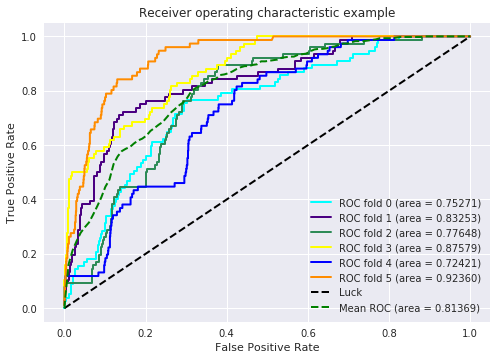

In [26]:
plot_roc(classifier_GB)

### AB

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


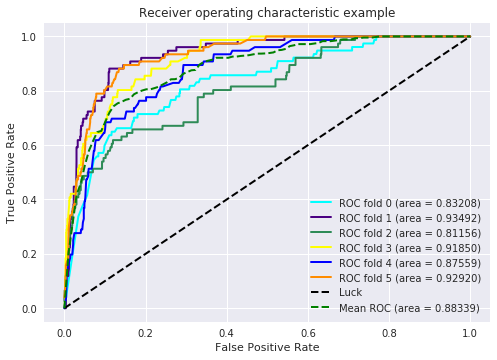

In [27]:
plot_roc(classifier_AB)

### RF

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


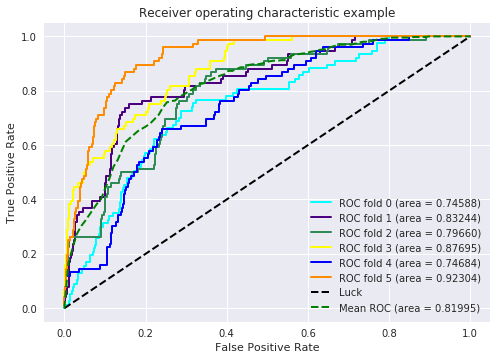

In [28]:
plot_roc(classifier_RF)

### ET

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


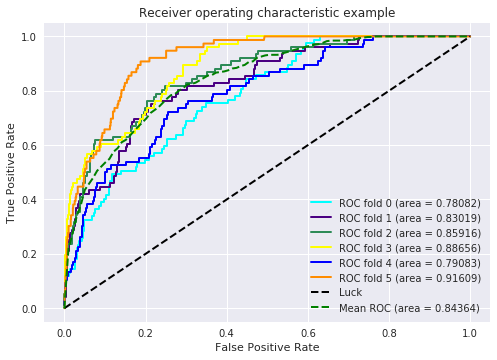

In [29]:
plot_roc(classifier_ET)

### BG

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


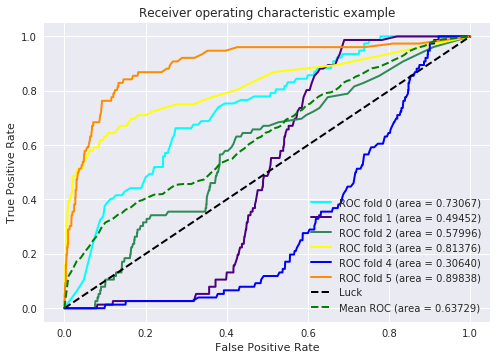

In [30]:
plot_roc(classifier_BG)

### LR

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


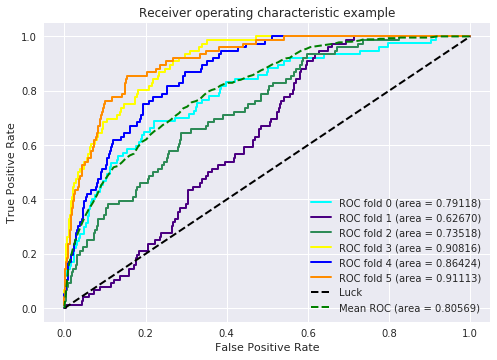

In [32]:
classifier_LR = LogisticRegression(random_state=rng) # score: 0.90199 (AUC 0.80569)
plot_roc(classifier_LR)

### SVC Linear

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


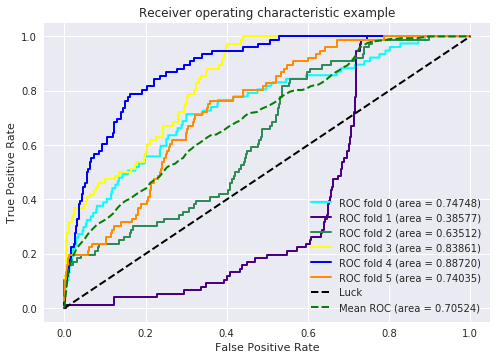

In [33]:
classifier_SVCL = svm.SVC(kernel='linear', probability=True, random_state=rng) # score: 0.89976 (AUC 0.70524)
plot_roc(classifier_SVCL)

### SVC RBF

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


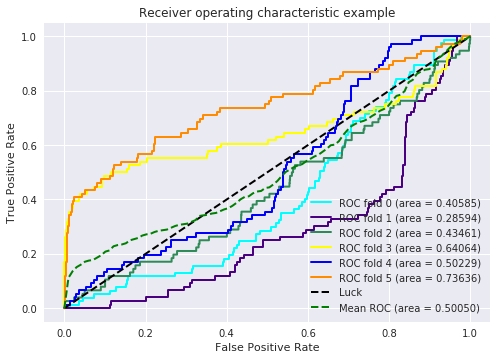

In [34]:
classifier_SVCR = svm.SVC(kernel='rbf', probability=True, random_state=rng) # score: 0.80188 (AUC 0.50050)
plot_roc(classifier_SVCR)

### KNN

In [35]:
# Find best 'n_neighbors':
import operator
from sklearn.cross_validation import train_test_split
n_neighbors_best_list = []
X_train, X_test, y_train, y_test = train_test_split(X, y)
for n_neighbors in [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]:
    knn = KNeighborsClassifier(n_neighbors) # score: 0.956583 (AUC 0.55841)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))
    n_neighbors_best_list.append(knn.score(X_test, y_test))

n_neighbors_best, n_neighbors_value = max(enumerate(n_neighbors_best_list), key=operator.itemgetter(1))
# print('\nBest n_neighbors is: %d \nwith value : %f' % (n_neighbors_best, n_neighbors_value))
print('\nBest value : %f' % (n_neighbors_value))
# plot_roc(KNeighborsClassifier(n_neighbors=n_neighbors_best))

/home/user/env_py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


1 0.930155733837
3 0.942425672487
5 0.949976403964
7 0.955639452572
9 0.954695611137
11 0.956583294007
13 0.955167531855
15 0.955167531855
17 0.953751769703
19 0.952807928268
21 0.953279848985
23 0.952807928268
25 0.952336007551
27 0.952807928268
29 0.951864086833
31 0.951864086833

Best value : 0.956583


/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


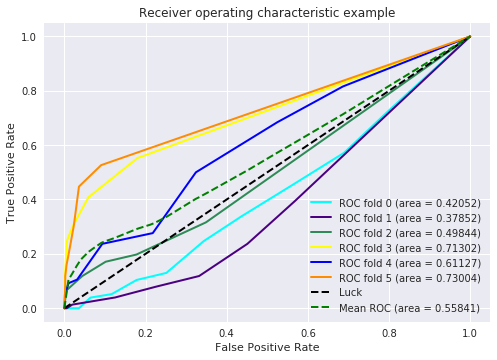

In [36]:
plot_roc(KNeighborsClassifier(n_neighbors=11))

### Benchmark of Kaggle progressive public leaderboard
Using Kaggle's 30% of actual reserved test data, top 1 & 2 team started from AUC=0.7+, progressing to 0.88+. Leaderboard feedback is expected to have contributed to a few 'jumps'.

<img align="left" src='./ref/LB-progress.png' width=100%>

<img align="left" src='./ref/LB-hist.png' width=100%>

### <font color='blue'>Reflection</font> 

<img align="right" src='./ref/output_71_1.png' width=50%>

* The best model here, AdaBoostClassifier, used 6-fold cross validation to reach average AUC 0.88, based on test data split from training data. If using 'Kaggle's 30% of actual reserved test data', AUC is expected to drop, nevertheless, I think the initial performance can be reasonably good due to the AUC margin: 0.88 - 0.7 = 0.18.

* Regarding the AUC score in ROC chart, when FPR is at 0.1, TPR is estimated at 0.7. Thus the model can correctly predict 320 out of 457 cases, at the expense of 802 (= 0.1 * 8018) false positive cases. The correctness is about: 320/1122 = 28.52%, which is five times better than 'guess of majority' 5.39% (= 457/8475)

|WnvPresent|Count|
|:---:|:---:
|0|8018
|1|457
|total|8475

# [5] What more can be done?

* Review confusion matrix. (High AUC doesn't translate to high accuracy of WNV identification. It's observed that improved AUC can deteriorate 'Averaged class error/accuracy' for WNV. Unbalanced classes, trade-off considerations.)
* Explore better strategy to use spray data, as 'feature importance' indicated: (Weighted) Number of Mosquitoes.
* Clustering method is effective, which is a form of building affiliation of relevant rows.
* Add heuristics, i.e. use geo-spacial distance of rows/samples to build sample affiliation.
* Ensemble several models, i.e. AdaBoost & ExtraTree, to complement CV Folde 2 performance.
* Consider to use Leaderboard feedback. (It seems that this WNV result submission is no longer available in Kaggle.)
* Quantify the benefit to use this model by comparing against current reactive practice.


# Appendices

### Model Feature Importances:

In [37]:
def util_feature_importances(classifier):
    print(classifier)
    dict_importance ={}
    for i in range(len(X_col)):
        dict_importance[X_col[i]] = classifier.feature_importances_[i]
        dict_importance_sort = sorted(dict_importance.items(), key=operator.itemgetter(1), reverse=True)
    return dict_importance_sort

In [38]:
util_feature_importances(classifier_GB)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto',
              random_state=<mtrand.RandomState object at 0x7fd94c68a3a8>,
              subsample=1.0, verbose=0, warm_start=False)


[('WeightNumMosquitosCombined', 0.15567517957580826),
 ('DeltaWeightNumMosPreTrapSpecies', 0.10479751253213301),
 ('NumMosquitosCombined', 0.10407077979486287),
 ('DeltaWeightNumMosPreBlockSpecies', 0.07662536399486948),
 ('DeltaWeightNumMosPreBlockTrap', 0.061457912097951095),
 ('nthDay', 0.057935351042958397),
 ('Sunrise', 0.052550411758991965),
 ('Sunset', 0.047729674265855566),
 ('WnvPresentPreBlockTrap', 0.043578679761810478),
 ('WnvPresentPreTrapSpecies', 0.040693088480034022),
 ('nthWeek', 0.034794223507233359),
 ('kmeans10', 0.032550598329972043),
 ('NumMosPreTrapSpecies', 0.028206036647372763),
 ('Month', 0.026981469402802574),
 ('WnvPresentPreBlockSpecies', 0.026566148960499081),
 ('NumMosPreBlockTrap', 0.020362620992609385),
 ('hclust10', 0.018193366372485007),
 ('Trap-ReCode', 0.014489343047961772),
 ('kmeans24', 0.0079211701859699859),
 ('WetBulb', 0.0059833573393557422),
 ('NumMosPreBlockSpecies', 0.0053276328898352798),
 ('Species-ReCode', 0.0034720661681162312),
 ('DewP

In [39]:
util_feature_importances(classifier_AB)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.004, n_estimators=1000,
          random_state=<mtrand.RandomState object at 0x7fd94c68a3a8>)


[('WeightNumMosquitosCombined', 0.36199999999999999),
 ('Trap-ReCode', 0.17299999999999999),
 ('kmeans10', 0.105),
 ('nthDay', 0.083000000000000004),
 ('Sunrise', 0.071999999999999995),
 ('NumMosPreBlockTrap', 0.070999999999999994),
 ('Sunset', 0.036999999999999998),
 ('Cool', 0.035000000000000003),
 ('Tavg', 0.033000000000000002),
 ('hclust10', 0.014999999999999999),
 ('NumMosquitosCombined', 0.0080000000000000002),
 ('WnvPresentPreTrapSpecies', 0.0030000000000000001),
 ('Month', 0.0030000000000000001),
 ('nthWeek', 0.0),
 ('ResultSpeed', 0.0),
 ('Depart', 0.0),
 ('AddressAccuracy', 0.0),
 ('DeltaWeightNumMosPreBlockSpecies', 0.0),
 ('ResultDir', 0.0),
 ('NumMosPreBlockSpecies', 0.0),
 ('Longitude', 0.0),
 ('DeltaTmin', 0.0),
 ('DeltaDewPoint', 0.0),
 ('Tmin', 0.0),
 ('DewPoint', 0.0),
 ('DeltaTmax', 0.0),
 ('Block-ReCode', 0.0),
 ('DeltaWeightNumMosPreTrapSpecies', 0.0),
 ('WnvPresentPreBlockTrap', 0.0),
 ('DeltaWeightNumMosPreBlockTrap', 0.0),
 ('WnvPresentPreBlockSpecies', 0.0),
 (

In [40]:
util_feature_importances(classifier_RF)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7fd94c68a3a8>,
            verbose=0, warm_start=False)


[('WeightNumMosquitosCombined', 0.13328372657830329),
 ('NumMosquitosCombined', 0.099972193438435428),
 ('DeltaWeightNumMosPreTrapSpecies', 0.094140978595867522),
 ('DeltaWeightNumMosPreBlockSpecies', 0.090800344198692456),
 ('DeltaWeightNumMosPreBlockTrap', 0.077191323330244602),
 ('Sunrise', 0.051731871136581072),
 ('Sunset', 0.042601467963614741),
 ('kmeans10', 0.042134164495757624),
 ('WnvPresentPreTrapSpecies', 0.038352624993064938),
 ('nthDay', 0.037542894097304318),
 ('NumMosPreTrapSpecies', 0.035590083800793364),
 ('nthWeek', 0.034696091166481834),
 ('Month', 0.031673090346076238),
 ('WnvPresentPreBlockTrap', 0.027750724649831703),
 ('NumMosPreBlockTrap', 0.021295034126122429),
 ('hclust10', 0.019688284296600144),
 ('Trap-ReCode', 0.019429801207890989),
 ('WnvPresentPreBlockSpecies', 0.015829494703700292),
 ('kmeans24', 0.013024880606700978),
 ('NumMosPreBlockSpecies', 0.0092158179858045728),
 ('Year', 0.006485600650471518),
 ('WetBulb', 0.006157136278378268),
 ('Species-ReCode

In [41]:
util_feature_importances(classifier_ET)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=3, max_features=10, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False,
           random_state=<mtrand.RandomState object at 0x7fd94c68a3a8>,
           verbose=0, warm_start=False)


[('WnvPresentPreTrapSpecies', 0.15733867957128728),
 ('WnvPresentPreBlockTrap', 0.10806957394339635),
 ('NumMosPreTrapSpecies', 0.094944994757077225),
 ('kmeans10', 0.094141624342161292),
 ('WeightNumMosquitosCombined', 0.069647344970214214),
 ('WnvPresentPreBlockSpecies', 0.049459012738412744),
 ('DeltaWeightNumMosPreTrapSpecies', 0.045793394767613502),
 ('DeltaWeightNumMosPreBlockSpecies', 0.040527723768405764),
 ('hclust10', 0.036062394685547138),
 ('NumMosquitosCombined', 0.03563153456034434),
 ('DeltaWeightNumMosPreBlockTrap', 0.031866975019225405),
 ('NumMosPreBlockTrap', 0.029118711450670839),
 ('Sunrise', 0.025796215368773853),
 ('Month', 0.024385255345821293),
 ('nthWeek', 0.022445262478846973),
 ('Trap-ReCode', 0.020443001202812311),
 ('Sunset', 0.018564412875929109),
 ('nthDay', 0.017995171419599838),
 ('Year', 0.012272686638788895),
 ('NumMosPreBlockSpecies', 0.009930672036037624),
 ('Species-ReCode', 0.0074796215916598432),
 ('kmeans24', 0.0064483291024809604),
 ('Cool', 0

### CV Score

In [42]:
n_folds = 6

In [43]:
# Gradient Boosting
cv = cross_val_score(classifier_GB,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('GB score: {0:.5f}'.format(cv.mean()))

GB score: 0.94608


In [44]:
# Ada Bossting
cv = cross_val_score(classifier_AB,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('AB score: {0:.5f}'.format(cv.mean()))

AB score: 0.92981


In [45]:
# Random Forest
cv = cross_val_score(classifier_RF,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('RF score: {0:.5f}'.format(cv.mean()))

RF score: 0.94407


In [46]:
# Extra Tree
cv = cross_val_score(classifier_ET,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('ET score: {0:.5f}'.format(cv.mean()))

ET score: 0.94643


In [47]:
# Bagging
cv = cross_val_score(classifier_BG,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('BG score: {0:.5f}'.format(cv.mean()))

BG score: 0.68328


In [48]:
# LR
classifier_LR = LogisticRegression(random_state=rng) # score: 0.91307 (AUC 0.80569)
cv = cross_val_score(classifier_LR,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('LR CV score: {0:.5f}'.format(cv.mean()))

LR CV score: 0.91307


In [49]:
# SVC Liner
classifier_SVCL = svm.SVC(kernel='linear', probability=True, random_state=rng) # score: 0.90034 (AUC 0.70524)
cv = cross_val_score(classifier_SVCL,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('SVC Liner CV score: {0:.5f}'.format(cv.mean()))

SVC Liner CV score: 0.90034


In [50]:
# SVC RBF
classifier_SVCR = svm.SVC(kernel='rbf', probability=True, random_state=rng) # score: 0.80023 (AUC 0.50050)
cv = cross_val_score(classifier_SVCR,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('SVC RBF CV score: {0:.5f}'.format(cv.mean()))

SVC RBF CV score: 0.80023


In [51]:
# KNN
classifier_KNN = KNeighborsClassifier(n_neighbors=11) # score: 0.90211 (AUC 0.55841)
cv = cross_val_score(classifier_KNN,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('KNN CV score: {0:.5f}'.format(cv.mean()))

KNN CV score: 0.90211


### ROC
<img align="left" src='./ref/ROC_curves.svg.png' width=100%>

---

### The End